In [1]:
from __future__ import print_function
import os
import sys
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, SimpleRNN, Activation, GRU, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import confusion_matrix, classification_report, cohen_kappa_score

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
base_dir = r'C:\Users\I\Desktop\Neural networks\Neural network data\Case3'
glove_dir = os.path.join(base_dir, 'glove.6B')
dataTrain = pd.read_csv(r'C:/Users/I/Desktop/Neural networks/Neural network data/Case3/drugsComTrain_raw.csv')
dataTest = pd.read_csv(r'C:/Users/I/Desktop/Neural networks/Neural network data/Case3/drugsComTest_raw.csv')

In [3]:
# Tokenize the text
samples = dataTrain['review']
samplesTest = dataTest['review']

tokenizer = Tokenizer(num_words = 5000)
tokenizer.fit_on_texts(samples)
tokenizer.fit_on_texts(samplesTest)
# Convert text to sequences
sequences = tokenizer.texts_to_sequences(samples)
sequencesTest = tokenizer.texts_to_sequences(samplesTest)

word_index = tokenizer.word_index

print('Found %s unique tokens in train data.' % len(word_index))

#pad sequences
Data = pad_sequences(sequences, maxlen=200)
DataTest = pad_sequences(sequencesTest, maxlen=200)

Found 55245 unique tokens in train data.


In [4]:
# Create three label categories for testing and training
# label = 2, when rating = 7-10
# label = 1, when rating = 4-7
# label = 0, when rating = 1-3
Labels = dataTrain['rating'].values
for i in range(len(Labels)):
    x = Labels[i]
    if x > 7:
        Labels[i] = 2
    elif x >= 4:
        Labels[i] = 1
    else:
        Labels[i] = 0

LabelsTest = dataTest['rating'].values
for i in range(len(LabelsTest)):
    x = LabelsTest[i]
    if x > 7:
        LabelsTest[i] = 2
    elif x >= 4:
        LabelsTest[i] = 1   
    else:
        LabelsTest[i] = 0           

In [5]:
Labels = to_categorical(np.asarray(Labels))
LabelsTest = to_categorical(np.asarray(LabelsTest))
print('Shape of train data tensor:', Data.shape)
print('Shape of train label tensor:', Labels.shape)
print('Shape of test data tensor:', DataTest.shape)
print('Shape of test label tensor:', LabelsTest.shape)

Shape of train data tensor: (161297, 200)
Shape of train label tensor: (161297, 3)
Shape of test data tensor: (53766, 200)
Shape of test label tensor: (53766, 3)


In [6]:
validation_split = 0.3
# split the data into a training set and a validation set
indices = np.arange(Data.shape[0])
np.random.shuffle(indices)
Data = Data[indices]
Labels = Labels[indices]
nb_validation_samples = int(validation_split * Data.shape[0])

x_train = Data[:-nb_validation_samples]
y_train = Labels[:-nb_validation_samples]
x_validation = Data[-nb_validation_samples:]
y_validation = Labels[-nb_validation_samples:]

Since now I'm using pre-trained word embeddings, I'll also need read the file containing values for the pre-trained word embedding. When reading the data in encoding="utf8" must be used or there will be errors, if you try reading the file in without it, it won't succeed since it raises an error, I don't know exactly what makes the error.

In [7]:
#make array for embeddings
embeddings_index = {}
#read the file and split the data inside
with open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf8") as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [8]:
num_words = min(5000, len(word_index) + 1)
#make array filled with zeroes
embedding_matrix = np.zeros((num_words, 200))
#for loop through the data and takes words to embedding_vector until 5000 words have been taken.
for word, i in word_index.items():
    if i >= 5000:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Set up embedding layer with parameters, notice that output dimension is now 200 instead of 100 since we are using 200 dimension glove.6B, also the weights now come from embedding_matrix and training is set to false since we don't want to train our pre-trained word embedding.

In [9]:
embedding_layer = Embedding(num_words,
                            200,
                            weights=[embedding_matrix],
                            input_length=200,
                            trainable=False)

In [10]:
sequence_input = Input(shape=(200,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)

prediction = Dense(3, activation='softmax')(x)

model = Model(sequence_input, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 200, 200)          1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, 196, 128)          128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 128)           82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 128)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 3, 128)            82048 

In [11]:
history = model.fit(x_train, y_train,
          batch_size=128,
          epochs=10,
          validation_data=(x_validation, y_validation))

Train on 112908 samples, validate on 48389 samples
Epoch 1/10
112908/112908 [==============================] - 84s 748us/sample - loss: 0.7849 - acc: 0.6683 - val_loss: 0.7018 - val_acc: 0.6928
Epoch 2/10
112908/112908 [==============================] - 80s 711us/sample - loss: 0.6387 - acc: 0.7335 - val_loss: 0.7328 - val_acc: 0.7120
Epoch 3/10
112908/112908 [==============================] - 82s 723us/sample - loss: 0.5627 - acc: 0.7680 - val_loss: 0.7049 - val_acc: 0.6980
Epoch 4/10
112908/112908 [==============================] - 80s 706us/sample - loss: 0.4984 - acc: 0.7968 - val_loss: 0.7080 - val_acc: 0.7196
Epoch 5/10
112908/112908 [==============================] - 75s 664us/sample - loss: 0.4379 - acc: 0.8250 - val_loss: 0.6437 - val_acc: 0.7488
Epoch 6/10
112908/112908 [==============================] - 84s 741us/sample - loss: 0.3810 - acc: 0.8506 - val_loss: 0.7237 - val_acc: 0.7518
Epoch 7/10
112908/112908 [==============================] - 85s 750us/sample - loss: 0.3354

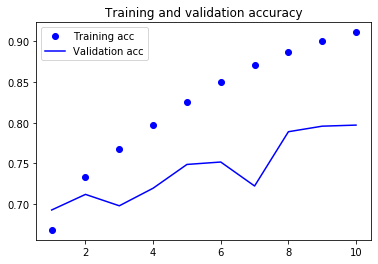

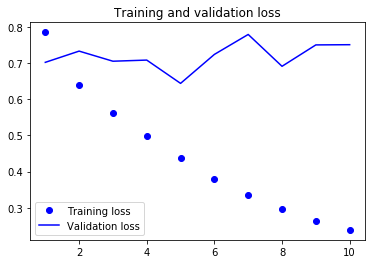

<Figure size 432x288 with 0 Axes>

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()
plt.show()

<Figure size 432x288 with 0 Axes>

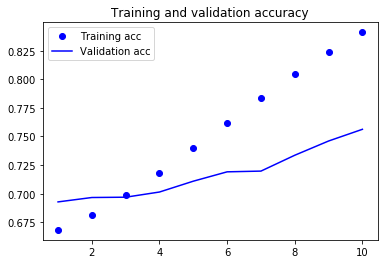

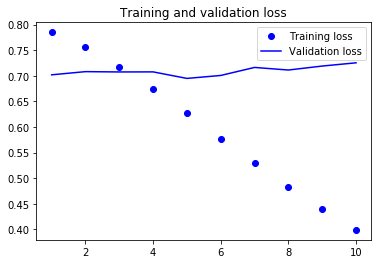

<Figure size 432x288 with 0 Axes>

In [13]:
epochs = range(1, len(acc) + 1)
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
plt.plot(epochs, smooth_curve(acc), 'bo', label='Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, smooth_curve(loss), 'bo', label='Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

As can been seen from the graphs above, model starts overfitting after 5 epochs. For example compared to trainable word embeddings the model in Case 3 Three rating categories glove.6B.200d V2 doesnt do better than in Case 3 Three rating categories V1 with trainable word embeddings. From here we can see that pre-trained word can sometimes be actually worse than trainable word embeddings. It starts to seem that the glove.6B isn't optimal word embedding for this data set.

In [14]:
# Find the predicted values for the test set
y_pred = np.argmax(model.predict(DataTest), axis = 1)
y_true = np.argmax(LabelsTest, axis = 1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred).T
print(cm)
print("\n")
# Calcualte classification report
cr = classification_report(y_true, y_pred)
print(cr)

[[ 8660  1469  1171]
 [ 1629  5004  1929]
 [ 1549  3106 29249]]


              precision    recall  f1-score   support

           0       0.77      0.73      0.75     11838
           1       0.58      0.52      0.55      9579
           2       0.86      0.90      0.88     32349

    accuracy                           0.80     53766
   macro avg       0.74      0.72      0.73     53766
weighted avg       0.79      0.80      0.79     53766



In [15]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.630
Cohen's kappa (quadratic) = 0.736


Accuracy and Cohen's kappa values are both worse than in previous version. Lets see what happens with we train the model from all over again with all of the training data.

In [17]:
sequence_input = Input(shape=(200,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Conv1D(128, 5, activation='relu')(embedded_sequences)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = MaxPooling1D(5)(x)
x = Conv1D(128, 5, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)

prediction = Dense(3, activation='softmax')(x)

model = Model(sequence_input, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

In [19]:
history = model.fit(Data, Labels,
          batch_size=128,
          epochs=5,
          validation_data=None)

Train on 161297 samples
Epoch 1/5
161297/161297 [==============================] - 111s 689us/sample - loss: 0.7345 - acc: 0.6889
Epoch 2/5
161297/161297 [==============================] - 107s 664us/sample - loss: 0.6067 - acc: 0.7469
Epoch 3/5
161297/161297 [==============================] - 110s 683us/sample - loss: 0.5407 - acc: 0.7768
Epoch 4/5
161297/161297 [==============================] - 109s 677us/sample - loss: 0.4868 - acc: 0.8022
Epoch 5/5
161297/161297 [==============================] - 111s 688us/sample - loss: 0.4390 - acc: 0.8228


In [20]:
# Find the predicted values for the validation set
y_pred = np.argmax(model.predict(DataTest), axis = 1)
y_true = np.argmax(LabelsTest, axis = 1)

# Calculate confusion matrix
cm = confusion_matrix(y_true, y_pred).T
print(cm)
print("\n")
# Calcualte classification report
cr = classification_report(y_true, y_pred)
print(cr)

[[ 7600  1196   596]
 [ 2815  4931  2475]
 [ 1423  3452 29278]]


              precision    recall  f1-score   support

           0       0.81      0.64      0.72     11838
           1       0.48      0.51      0.50      9579
           2       0.86      0.91      0.88     32349

    accuracy                           0.78     53766
   macro avg       0.72      0.69      0.70     53766
weighted avg       0.78      0.78      0.78     53766



In [21]:
# Calculate the cohen's kappa, both with linear and quadratic weights
k = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's kappa (linear)    = {k:.3f}")
k2 = cohen_kappa_score(y_true, y_pred, weights = 'quadratic')
print(f"Cohen's kappa (quadratic) = {k2:.3f}")

Cohen's kappa (linear)    = 0.592
Cohen's kappa (quadratic) = 0.738


I would have thought that since we are using a pretrained word embedding, the results would have been better with 5 epochs of train but it seems not. I think this is because the model still trains its weights and even if you're starting to overfit after the fifth epoch, the weights still improve somewhat. <br><br>Next lets try how we can classify with six classes in Case 3 Six rating categories V1.